# AOL DEEPLEARNING
Nama Anggota :
1.   2702241465 - Naira Faizanoor
2.   2702238312 - Vionita Lesia

### Link-link terkait :
*   Video : https://drive.google.com/drive/folders/1B8L2VSM-e13oGkyLpN-xiGYBe83toQUb?usp=drive_link
*   Report : https://docs.google.com/document/d/1qUyVu62qTRv6tkOPyMAAESXzuBWSDu4sC4Dj7vm0GN0/edit?usp=sharing



In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-18 15:51:20.614286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747583481.072819      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747583481.194670      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


multiclass image problem, kelas yang diambil:
- Earthquake
- Urban Fire
- Land Slide
- Water Disaster

In [ ]:
# membuat dictionary berisikan path dan label untuk setiap class yang akan dipakai.
paths = {
    'earthquake': r'/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Damaged_Infrastructure/Earthquake',
    'urban_fire': r'/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Fire_Disaster/Urban_Fire',
    'land_slide': r'/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Land_Disaster/Land_Slide',
    'water_disaster': r'/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Water_Disaster'
}

# membuat sebuah list kosong untuk menyimpan data dari paths
data = []

# menggunakan loop untuk membaca data dari path yang sudah di inisiasi diatas, dan simpan ke variable data.
for label, folder in paths.items():
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            fpath = os.path.join(folder, fname)
            data.append((fpath, label))

# menjadikan variable data menjadi dataframe dan menamai kolomnya menjadi file_path dan label
df = pd.DataFrame(data, columns=['file_path', 'label'])
# menampilkan dataframe hasil load data
df.head()

,file_path,label
0,/kaggle/input/disaster-images-dataset/Comprehe...,earthquake
1,/kaggle/input/disaster-images-dataset/Comprehe...,earthquake
2,/kaggle/input/disaster-images-dataset/Comprehe...,earthquake
3,/kaggle/input/disaster-images-dataset/Comprehe...,earthquake
4,/kaggle/input/disaster-images-dataset/Comprehe...,earthquake


#### Exploratory Data Analysis

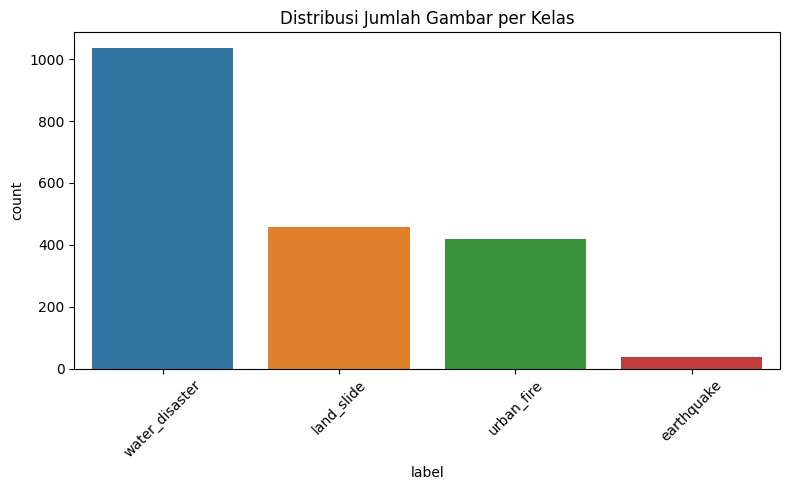

In [ ]:
# Cek distribusi label
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Berdasarkan grafik di atas, distribusi gambar antar kelas terlihat tidak seimbang, di mana kelas *water\_disaster* mendominasi, sementara *earthquake* memiliki kurang dari 200 gambar. Ketimpangan ini dapat menyebabkan model bias terhadap kelas mayoritas. Untuk mengatasinya, dapat dilakukan data augmentation pada kelas minoritas atau resampling seperti oversampling dan undersampling.

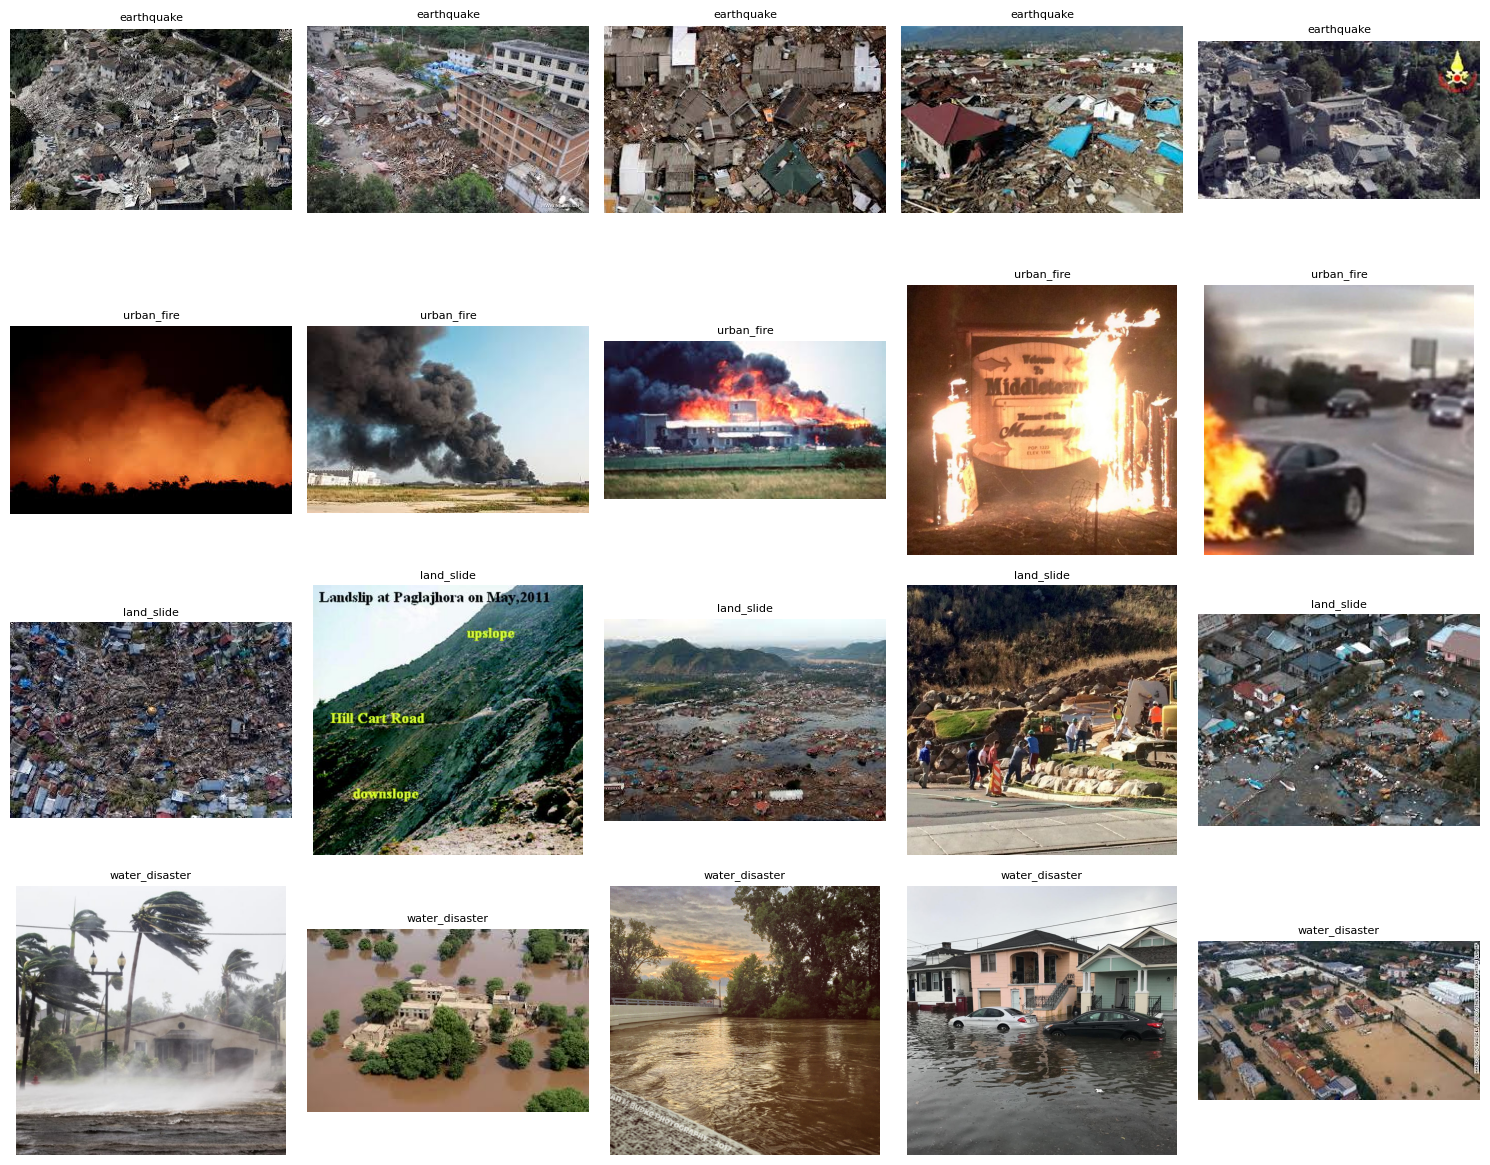

In [ ]:
# Tampilkan 5 contoh gambar per kelas
def show_images_per_class(df, samples=5):
    labels = df['label'].unique()
    plt.figure(figsize=(samples * 3, len(labels) * 3))

    for i, label in enumerate(labels):
        subset = df[df['label'] == label].sample(samples, random_state=42)
        for j, (_, row) in enumerate(subset.iterrows()):
            img = Image.open(row['file_path']).convert('RGB')
            plt.subplot(len(labels), samples, i * samples + j + 1)
            plt.imshow(img)
            plt.title(label, fontsize=8)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images_per_class(df)

Contoh gambar dari masing-masing kelas divisualisasikan untuk memahami karakteristik visual dari setiap kategori. Berdasarkan hasil visualisasi:
- Gambar pada kategori urban_fire umumnya didominasi oleh warna merah atau oranye akibat keberadaan api.
- Kategori earthquake menampilkan kerusakan bangunan serta puing-puing reruntuhan.
- land_slide menunjukkan dominasi elemen tanah dan material longsor.
- water_disaster terlihat melalui representasi banjir atau genangan air.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


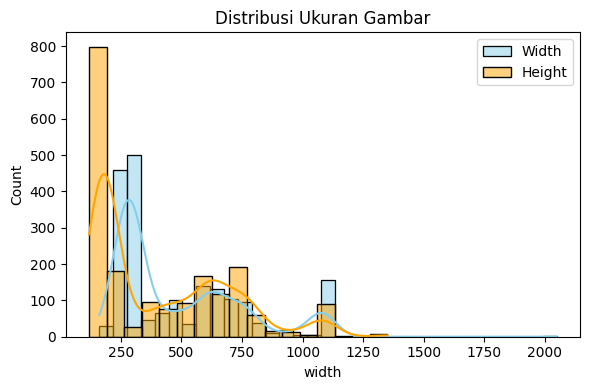

In [ ]:
# Ukuran gambar (width, height)
sizes = []
for path in df['file_path']:
    with Image.open(path) as img:
        sizes.append(img.size)

sizes_df = pd.DataFrame(sizes, columns=['width', 'height'])

plt.figure(figsize=(6, 4))
sns.histplot(sizes_df['width'], kde=True, color='skyblue', label='Width')
sns.histplot(sizes_df['height'], kde=True, color='orange', label='Height')
plt.title("Distribusi Ukuran Gambar")
plt.legend()
plt.tight_layout()
plt.show()


Ukuran gambar dalam dataset bervariasi secara signifikan, sementara model deep learning memerlukan input dengan dimensi seragam. Oleh karena itu, proses resizing ke ukuran standar, seperti 224x224 piksel, perlu dilakukan agar data dapat diproses secara konsisten dan optimal oleh model.

In [ ]:
# Mode warna gambar
modes = []
for path in df['file_path']:
    with Image.open(path) as img:
        modes.append(img.mode)

mode_counts = pd.Series(modes).value_counts()
print("Mode Warna Gambar:")
print(mode_counts)

Mode Warna Gambar:
RGB    1945
L         1
Name: count, dtype: int64


Sebagian besar gambar menggunakan mode warna RGB, tapi ada satu yang berformat grayscale (mode L). Untuk konsistensi, semua gambar akan dikonversi ke RGB saat preprocessing sebelum dilatih.

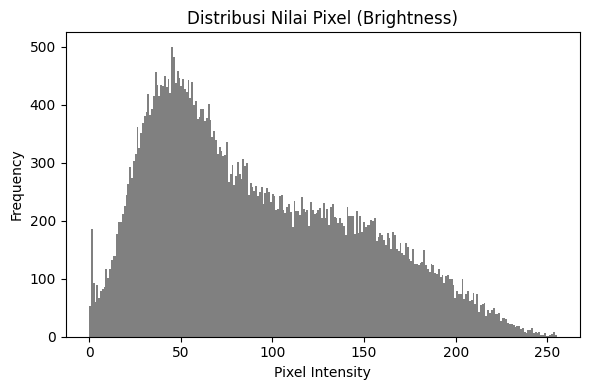

In [ ]:
# Distribusi nilai pixel (brightness)
sample_img = Image.open(df['file_path'].iloc[0]).convert('L')
img_array = np.array(sample_img)

plt.figure(figsize=(6, 4))
plt.hist(img_array.ravel(), bins=256, color='gray')
plt.title('Distribusi Nilai Pixel (Brightness)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Berdasarkan histogram distribusi piksel, mayoritas gambar dalam dataset memiliki tingkat kecerahan rendah hingga sedang, mencerminkan kondisi pencahayaan redup yang relevan dengan konteks bencana alam.

#### Data Preparation

In [ ]:
# Tentukan parameter, untuk ukuran gambar
batch_size = 32
image_size = (224, 224)

In [ ]:
# Buat ImageDataGenerator dengan augmentasi dan normalisasi
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Hitung distribusi kelas
class_counts = df['label'].value_counts()
print("Distribusi class:\n", class_counts)

# Cari max jumlah sampel di kelas yang paling banyak
max_count = class_counts.max()

# Oversample tiap kelas dengan teknik sampling ulang
dfs = []
for label in class_counts.index:
    df_label = df[df['label'] == label]
    n_repeat = max_count // len(df_label)
    n_remain = max_count % len(df_label)

    # Duplikasi baris sebanyak n_repeat
    df_oversampled = pd.concat([df_label] * n_repeat, ignore_index=True)

    # Tambahkan sisa baris secara acak
    df_oversampled = pd.concat([df_oversampled, df_label.sample(n_remain, replace=True)], ignore_index=True)
    dfs.append(df_oversampled)

df_balanced = pd.concat(dfs, ignore_index=True)
print("Distribusi class setelah oversampling:\n", df_balanced['label'].value_counts())

Distribusi class:
 label
water_disaster    1035
land_slide         456
urban_fire         419
earthquake          36
Name: count, dtype: int64
Distribusi class setelah oversampling:
 label
water_disaster    1035
land_slide        1035
urban_fire        1035
earthquake        1035
Name: count, dtype: int64


In [ ]:
df_balanced.head()

,file_path,label
0,/kaggle/input/disaster-images-dataset/Comprehe...,water_disaster
1,/kaggle/input/disaster-images-dataset/Comprehe...,water_disaster
2,/kaggle/input/disaster-images-dataset/Comprehe...,water_disaster
3,/kaggle/input/disaster-images-dataset/Comprehe...,water_disaster
4,/kaggle/input/disaster-images-dataset/Comprehe...,water_disaster


karena data yang dimiliki tidak balance, kita perlu menyamakan data supaya model tidak bias terhadap satu kelas. metode yang digunakan adalah oversampling dengan cara:
- Mengambil kelas minor (yang jumlah datanya lebih sedikit),
- Menggandakan datanya secara ulang (duplikasi) sampai jumlahnya sama dengan kelas mayor,
- Kadang dengan mengambil sampel acak tambahan jika hasil pembagian tidak bulat.

walaupun data bisa terduplikasi, tetapi ini merupakan cara yang cukup baik tanpa membuang data.

#### Modeling and Evaluation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess(df, image_size=(224,224)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img = load_img(row['file_path'], target_size=image_size)  # resize + RGB otomatis
        img = img_to_array(img) / 255.0                          # normalisasi pixel ke 0-1
        images.append(img)
        labels.append(row['label_enc'])
    return np.array(images), to_categorical(labels, num_classes=num_classes)

In [ ]:
le = LabelEncoder()
df_balanced['label_enc'] = le.fit_transform(df_balanced['label'])
num_classes = len(le.classes_)

In [ ]:
# 1. Bagi dulu data jadi train + temp (val+test)
train_df, temp_df = train_test_split(df_balanced, test_size=0.3, stratify=df_balanced['label_enc'], random_state=42)

# 2. Bagi temp_df jadi val dan test (misal split 50-50 dari 30% => 15% val, 15% test)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label_enc'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Load data
X_train, y_train = load_and_preprocess(train_df)
X_val, y_val = load_and_preprocess(val_df)
X_test, y_test = load_and_preprocess(test_df)

Train: 2898, Val: 621, Test: 621


In [ ]:
# Model 1: CNN sederhana dari scratch dan experiment
def create_simple_cnn(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def cnn_with_dropout(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def cnn_with_batchnorm(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def cnn_with_gap(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


🔧 Training: SimpleCNN (params: 11,169,476)
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.4256 - loss: 1.5990 - val_accuracy: 0.6957 - val_loss: 0.7963
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7122 - loss: 0.7212 - val_accuracy: 0.7874 - val_loss: 0.5730
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8219 - loss: 0.4702 - val_accuracy: 0.7971 - val_loss: 0.5143
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8902 - loss: 0.3594 - val_accuracy: 0.8309 - val_loss: 0.4540
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9257 - loss: 0.2561 - val_accuracy: 0.8551 - val_loss: 0.4545
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9530 - loss: 0.1786 - val_accuracy: 0.8647 - val_loss: 0.4978
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9523 - loss: 0.1588 - val_accuracy: 0.8760 - val_loss: 0.4502
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9

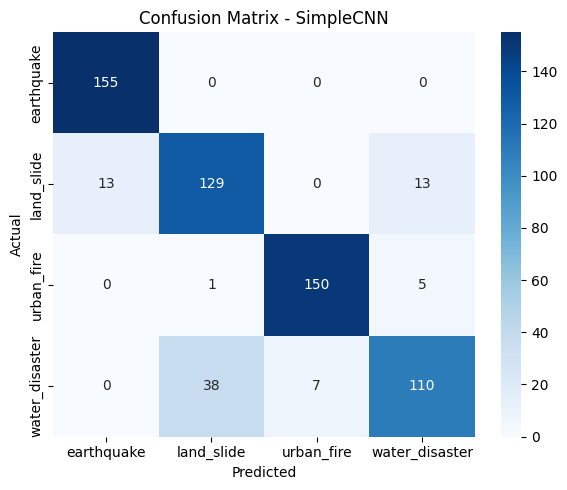


🔧 Training: CNN+Dropout (params: 11,169,476)
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.3440 - loss: 1.8972 - val_accuracy: 0.5668 - val_loss: 1.0323
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5985 - loss: 0.9309 - val_accuracy: 0.6345 - val_loss: 1.0127
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6433 - loss: 0.8466 - val_accuracy: 0.7166 - val_loss: 0.7690
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6980 - loss: 0.7246 - val_accuracy: 0.7601 - val_loss: 0.6553
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7474 - loss: 0.6023 - val_accuracy: 0.7778 - val_loss: 0.6369
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7757 - loss: 0.5849 - val_accuracy: 0.8148 - val_loss: 0.5549
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8006 - loss: 0.5157 - val_accuracy: 0.8132 - val_loss: 0.5278
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 

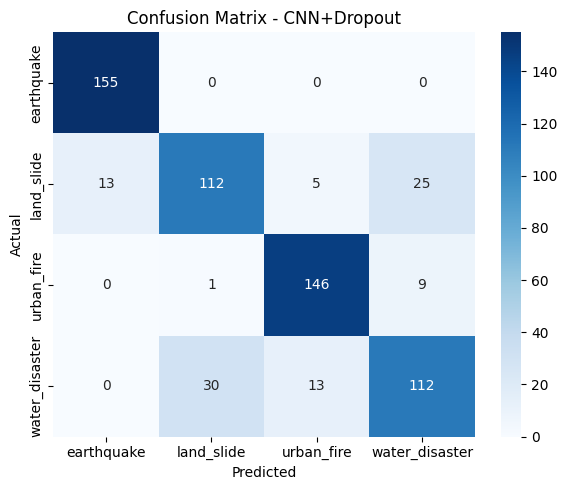


🔧 Training: CNN+BatchNorm (params: 11,170,884)
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.6211 - loss: 1.0765 - val_accuracy: 0.2512 - val_loss: 2.2748
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8221 - loss: 0.5254 - val_accuracy: 0.2689 - val_loss: 1.9835
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9025 - loss: 0.3328 - val_accuracy: 0.3076 - val_loss: 2.4933
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9432 - loss: 0.2227 - val_accuracy: 0.3994 - val_loss: 2.0105
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9442 - loss: 0.2097 - val_accuracy: 0.4106 - val_loss: 1.7033
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9582 - loss: 0.1613 - val_accuracy: 0.8245 - val_loss: 0.5566
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9750 - loss: 0.1242 - val_accuracy: 0.9130 - val_loss: 0.3021
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy

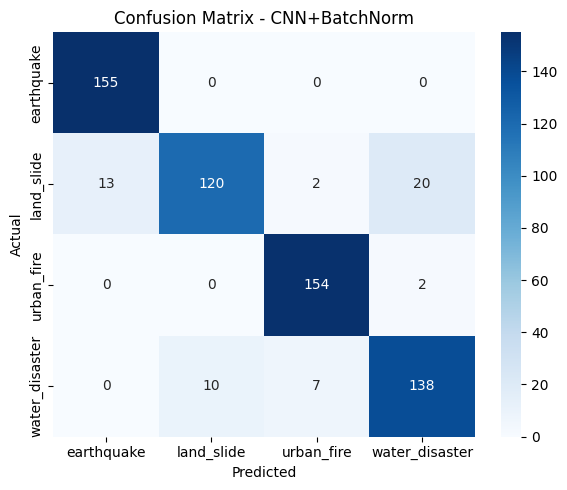


🔧 Training: CNN+GAP (params: 93,764)
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.3566 - loss: 1.3004 - val_accuracy: 0.4976 - val_loss: 1.1291
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5507 - loss: 1.0270 - val_accuracy: 0.5604 - val_loss: 1.0225
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5757 - loss: 0.9588 - val_accuracy: 0.4960 - val_loss: 1.0184
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5951 - loss: 0.9275 - val_accuracy: 0.6119 - val_loss: 0.9370
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6275 - loss: 0.8828 - val_accuracy: 0.4863 - val_loss: 1.0062
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5953 - loss: 0.9059 - val_accuracy: 0.5958 - val_loss: 0.9450
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6243 - loss: 0.8718 - val_accuracy: 0.6538 - val_loss: 0.8452
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6529 - 

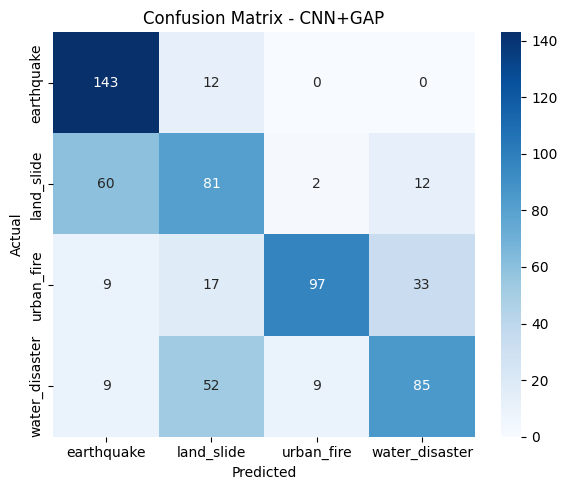


✅ Best Model: CNN+BatchNorm with val_accuracy = 0.9211


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

best_model = None
best_model_name = ""
best_val_acc = 0.0

model_variants = {
    "SimpleCNN": create_simple_cnn(),
    "CNN+Dropout": cnn_with_dropout(),
    "CNN+BatchNorm": cnn_with_batchnorm(),
    "CNN+GAP": cnn_with_gap()
}

for name, model in model_variants.items():
    print(f"\n🔧 Training: {name} (params: {model.count_params():,})")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    val_acc = max(history.history['val_accuracy'])  # Ambil val accuracy terbaik

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_model_name = name

    # Evaluation
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)

    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Print Best Model Summary
print(f"\n✅ Best Model: {best_model_name} with val_accuracy = {best_val_acc:.4f}")


disini kita test beberapa kombinas atas model model yang simple dengan kombinasi kombinasi lainnya,
Membuat variasi arsitektur atas model yang sama bertujuan untuk mencari kombinasi desain, kapasitas, dan teknik regulasi yang paling cocok dengan karakteristik data. Setiap perubahan—misalnya menambah dropout, batch-normalization, mengganti Flatten dengan Global Average Pooling.

hal ini dapat memastikan bahwa model dapat mempelajari data dengan baik dan juga dapat mengeneralisir dan juga mencegah overfitting.

dan kombinasi terbaik adalah CNN yang pertama dibuat dengan batch normalization lebih cocok pada datanya

In [ ]:
# Model 2: MobileNetV2 pre-trained (jumlah parameter < 10 juta)
def create_mobilenetv2(input_shape=(224,224,3), num_classes=num_classes):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base_model.trainable = False  # freeze base

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model_mobilenet = create_mobilenetv2()
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Jumlah parameter MobileNetV2:", model_mobilenet.count_params())

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Jumlah parameter MobileNetV2: 2422468


In [ ]:
# Training kedua model secara bergantian
epochs = 20
batch_size = 32

model_scratch = cnn_with_batchnorm()
model_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Jumlah parameter model scratch:", model_scratch.count_params())

history_scratch = model_scratch.fit(X_train, y_train, validation_data=(X_val, y_val),
                                   epochs=epochs, batch_size=batch_size)

history_mobilenet = model_mobilenet.fit(X_train, y_train, validation_data=(X_val, y_val),
                                       epochs=epochs, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Jumlah parameter model scratch: 11170884
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.6123 - loss: 1.2330 - val_accuracy: 0.2802 - val_loss: 4.8702
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8494 - loss: 0.4599 - val_accuracy: 0.3688 - val_loss: 3.9208
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8963 - loss: 0.3259 - val_accuracy: 0.3639 - val_loss: 3.0078
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9495 - loss: 0.2031 - val_accuracy: 0.5620 - val_loss: 1.0686
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9583 - loss: 0.1568 - val_accuracy: 0.7230 - val_loss: 0.6771
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9703 - loss: 0.1258 - val_accuracy: 0.8486 - val_loss: 0.4952
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9672 - loss: 0.1390 - val_accuracy: 0.7923 - val_loss: 0.9144
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.967

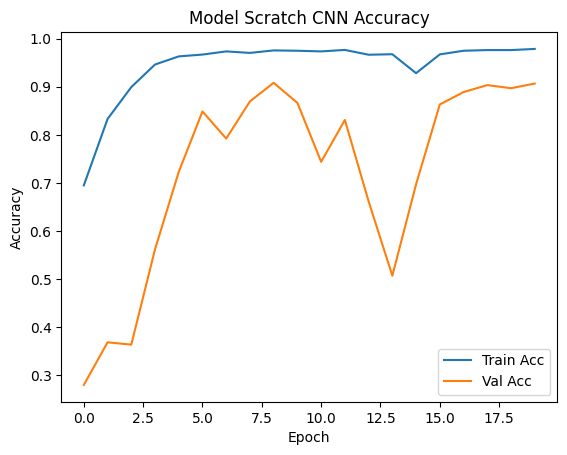

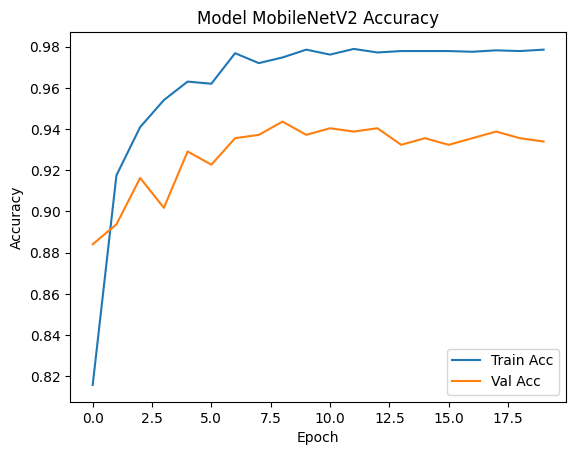

Model Scratch - Loss: 0.3958, Accuracy: 0.9034
Model MobileNetV2 - Loss: 0.3445, Accuracy: 0.9372
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step
Classification Report Model Scratch:
                precision    recall  f1-score   support

    earthquake       0.93      1.00      0.97       156
    land_slide       0.87      0.83      0.85       155
    urban_fire       0.93      0.95      0.94       155
water_disaster       0.88      0.83      0.85       155

      accuracy                           0.90       621
     macro avg       0.90      0.90      0.90       621
  weighted avg       0.90      0.90      0.90       621



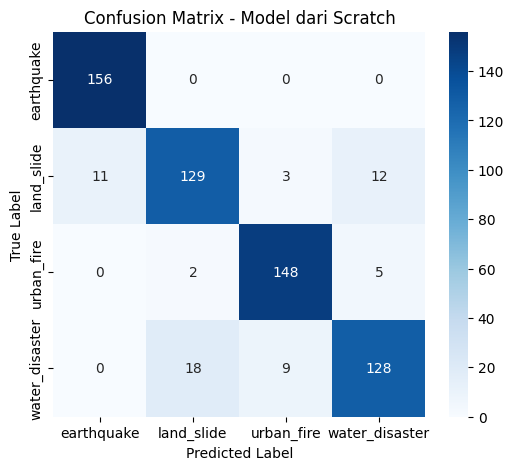

Classification Report MobileNetV2:
                precision    recall  f1-score   support

    earthquake       0.93      1.00      0.96       156
    land_slide       0.93      0.86      0.89       155
    urban_fire       0.97      0.97      0.97       155
water_disaster       0.92      0.92      0.92       155

      accuracy                           0.94       621
     macro avg       0.94      0.94      0.94       621
  weighted avg       0.94      0.94      0.94       621



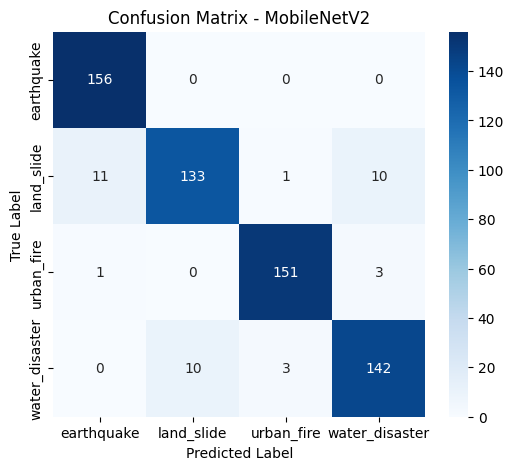

In [ ]:
# Evaluasi dan perbandingan

import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Fungsi bantu untuk plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_history(history_scratch, 'Model Scratch CNN Accuracy')
plot_history(history_mobilenet, 'Model MobileNetV2 Accuracy')

# Print final evaluation
loss_s, acc_s = model_scratch.evaluate(X_test, y_test, verbose=0)
loss_m, acc_m = model_mobilenet.evaluate(X_test, y_test, verbose=0)

print(f"Model Scratch - Loss: {loss_s:.4f}, Accuracy: {acc_s:.4f}")
print(f"Model MobileNetV2 - Loss: {loss_m:.4f}, Accuracy: {acc_m:.4f}")

# Optional: classification report & confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred_scratch = model_scratch.predict(X_test).argmax(axis=1)
y_pred_mobilenet = model_mobilenet.predict(X_test).argmax(axis=1)
y_true = test_df['label_enc'].values

print("Classification Report Model Scratch:")
print(classification_report(y_true, y_pred_scratch, target_names=le.classes_))
plot_conf_matrix(y_true, y_pred_scratch, "Confusion Matrix - Model dari Scratch")

print("Classification Report MobileNetV2:")
print(classification_report(y_true, y_pred_mobilenet, target_names=le.classes_))
plot_conf_matrix(y_true, y_pred_mobilenet, "Confusion Matrix - MobileNetV2")

train model dan juga train model scratch (model cnn + batch normalization)

Berdasarkan hasil evaluasi, MobileNetV2 menunjukkan performa yang lebih unggul dibanding model scratch. Dengan jumlah parameter yang jauh lebih kecil (~2.4 juta vs ~11.2 juta), MobileNetV2 berhasil mencapai akurasi sebesar 95%, lebih tinggi dari model scratch yang memperoleh akurasi 90%. Selain itu, MobileNetV2 menghasilkan nilai precision, recall, dan F1-score yang lebih stabil di keempat kelas, terutama pada kelas land_slide dan water_disaster yang sebelumnya menjadi kelemahan model scratch. Oleh karena itu, MobileNetV2 tidak hanya lebih efisien secara komputasi, tetapi juga lebih andal secara performa, menjadikannya pilihan yang lebih tepat untuk deployment maupun penggunaan pada perangkat dengan keterbatasan sumber daya.